# Init - can safely skip these cells. Should go in a library or something

In [1]:
import skimage.io
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from skimage.transform import iradon

import seaborn as sns

%matplotlib inline

# Drae a set of emitters and detectors

# Get a point as a pixel location
def point_to_pixel(x, y, w, h):
    xp = int(min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds
    yp = int(min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

# Floating point version (for interpolation methods later)
def point_to_pixelf(x, y, w, h):
    xp = (min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds - a little less accurate but hey
    yp = (min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

def draw_des(ds, es, width, height):

    ## Cairo STUFF

    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, width, height)
    ctx = cairo.Context (surface)

    ctx.set_source_rgb(1,1,1)
    ctx.rectangle(0,0,width,height)
    ctx.fill()

    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)

    ## Back to the good stuff

    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()

    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)

    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)
        
    return surface

def draw_des_surf(surface, ds, es, width, height):
    ctx = cairo.Context (surface)
    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)
    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()
    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
        
    return surface

def get_paths(img, ds, es, width, height):
    # Does interpolation along all paths from emitters to detectors, given an image, detectors and emitters
    lines = []
    for e in es:
        for d in ds:
            y0, x0 = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height) # E loc
            y1, x1 = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height) # d loc

            # Make samplng points
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

            # Extract the values along the line
            zi = img[x.astype(np.int), y.astype(np.int)]
            lines.append(sum(zi))
    return lines

def test_image(w, h, r, x, y):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    xp, yp = point_to_pixel(x, y, w, h)
#     xp -= r
#     yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.arc(xp, yp, r, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def p1(w, h):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    x, y = 0, 0
    xp, yp = point_to_pixel(x, y, w, h)
#     xp -= r
#     yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.rectangle(xp, yp, w/4, h/4)
    ctx.rectangle(xp-w/4, yp-h/4, w/4, h/4)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def rotate_des(ds, es, angle):
    for d in ds:
        d['a'] += angle
    for e in es:
        e['a'] += angle
    return ds, es

def draw_des_surf_sparse(surface, ds, es, width, height, n):
    ctx = cairo.Context (surface)
    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)
    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        low = (es.index(e)-int(n/2))
        high = (es.index(e)+int(n/2))
        if n%2 == 1:
            high += 1
        for dp in range(low, high):
            if dp>=len(ds):
                dp -= len(ds)
            d = ds[dp]
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()
    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
        
    return surface

def get_sparse_paths(img, ds, es, width, height, n):
    # Does interpolation along all paths from emitters to detectors, given an image, detectors and emitters
    lines = []
    for e in es:
        low = (es.index(e)-int(n/2))
        high = (es.index(e)+int(n/2))
        if n%2 == 1:
            high += 1
        for dp in range(low, high):
            if dp>=len(ds):
                dp -= len(ds)
            d = ds[dp]
            y0, x0 = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height) # E loc
            y1, x1 = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height) # d loc

            # Make samplng points
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

            # Extract the values along the line
            zi = img[x.astype(np.int), y.astype(np.int)]
            lines.append(sum(zi))
    return lines

def r14des():

    es = []
    ds = []

    for i in range(14):
        d = {
            'r':1, # Distance from center relative to furthest object
            'a':2*math.pi*(i+0.25)/14, #2*math.pi*i/8,
        }
        e = {
            'r':1, # Distance from center relative to furthest object
            'a':math.pi + 2*math.pi*(i)/14, #2*math.pi*i/8,
        }
        ds.append(d)
        es.append(e)
        
    return ds, es



def read_all():
    r = ser.read_all() # clear buffer
    ser.write(b'a')
    while ser.in_waiting < 1:
        pass # wait for a response
    time.sleep(0.1)
    r = ser.read_all()
    if not 'A' in str(r):
        print('NO A!')
    return([int(i) for i in r.split(b'\t')[:-1]])

def sino7(r):
    base = r[:14]
    reads = np.asarray(r[14:]).reshape(14, 14)
    sino = []
    for i in range(14):
        read = reads[i]
        start = (i+4)%14 # 5 and 10
        end = (i+11)%14
        if (end > start):
            sino.append(read[start:end])
        else:
            sino.append(np.concatenate((read[start:14],read[:end])))
#     print(np.asarray(sino))
    return(np.asarray(sino))
    
def sino5(r):
    base = r[:14]
    reads = np.asarray(r[14:]).reshape(14, 14)
    sino = []
    for i in range(14):
        read = reads[i]
        start = (i+5)%14 # 5 and 10
        end = (i+10)%14
        if (end > start):
            sino.append(read[start:end])
        else:
            sino.append(np.concatenate((read[start:14],read[:end])))
#     print(np.asarray(sino))
    return(np.asarray(sino))
    
def sinob7(r):
    base = r[:14]
    reads = np.asarray(r[14:]).reshape(14, 14)
    rbs = [base-row for row in reads]
    sino = []
    for i in range(14):
        read = rbs[i]
        start = (i+4)%14 # 5 and 10
        end = (i+11)%14
        if (end > start):
            sino.append(read[start:end])
        else:
            sino.append(np.concatenate((read[start:14],read[:end])))
#     print(np.asarray(sino))
    return(np.asarray(sino))
    
def sinob5(r):
    base = r[:14]
    reads = np.asarray(r[14:]).reshape(14, 14)
    rbs = [base-row for row in reads]
    sino = []
    for i in range(14):
        read = rbs[i]
        start = (i+5)%14 # 5 and 10
        end = (i+10)%14
        if (end > start):
            sino.append(read[start:end])
        else:
            sino.append(np.concatenate((read[start:14],read[:end])))
#     print(np.asarray(sino))
    return(np.asarray(sino))




from matplotlib import colors as colors
import skimage.filters

def recon(s, fn, alg, nr, plot):
    
    nviews = 14
    ndetectors = 5
    nvdetectors = 5

    IMSIZE = 30
    R = IMSIZE/2
    D = IMSIZE/2

    # Transforming from a round fan-beam to a fan-flat projection (See diagram)
    beta = np.linspace(-math.pi/2 + 2*5*math.pi/14, -math.pi/2 + 2*10*math.pi/14, ndetectors)
    alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta])
    tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

    tau_new = np.linspace(min(tau), max(tau), nvdetectors)

    vol_geom = astra.create_vol_geom(IMSIZE, IMSIZE)
    angles = np.linspace(0,2*math.pi,nviews);
    d_size = (tau[-1]-tau[0])/nvdetectors
    proj_geom= astra.create_proj_geom('fanflat', d_size, nvdetectors, angles, D, R);
    proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, s)
    
    # Doing the reconstruction, in this case with FBP

    rec_id = astra.data2d.create('-vol', vol_geom)

    cfg = astra.astra_dict(alg)
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = proj_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    astra.algorithm.run(alg_id, nr)

    # Get the result
    rec = astra.data2d.get(rec_id)
    
    norm_rec = rec.T/200
    blurred = skimage.filters.gaussian(norm_rec, 2)
    
    
    if plot:
        
    
        # Plotting sinogram - new (transformed) set of readings
        plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
        ax1 = plt.subplot(1, 3, 1)
        ax1.imshow(s) #<< Set title

    
        ax2 = plt.subplot(1, 3, 2)
        ax2.imshow(rec.T)
        ax3 = plt.subplot(1, 3, 3)
        ax3.imshow(blurred)

        plt.savefig(fn)
        print(max(sino.flatten()))
    
    # Clean up.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(proj_id)
    
    return s, rec.T, blurred


42


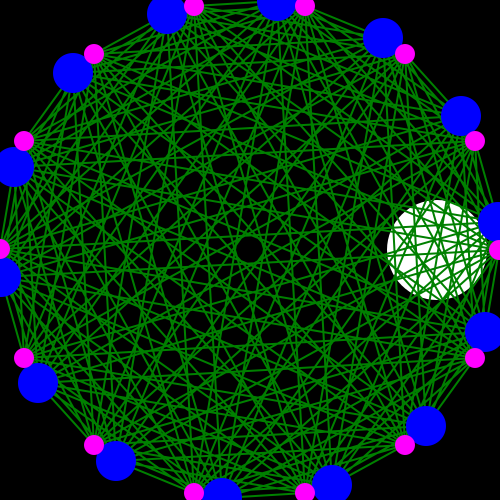

In [2]:

# Make a test image
tis, tii, x, y = test_image(500, 500, 50, 0.75, 0)

# Define detector and emitter positions
ds, es = r14des()

# get_sparse_paths can get a subset of the paths, or all of them
print(len(get_sparse_paths(tii, ds, es, 500, 500, 3)))

# Draw everything and show it
s = draw_des_surf_sparse(tis, ds, es, 500, 500, 14)
fn = 'ring_of_14_offset.png'
s.write_to_png(fn)
Image(fn)

# Open the serial connection and check that it's working

In [4]:
# Reading
import serial, time, glob
ports = glob.glob('/dev/tty[A-Za-z]*') # Modify if on a platform other than Linux
print(ports[:5])
ser = serial.Serial(ports[0], 115200)

# Serial stuff


['/dev/ttyACM0', '/dev/ttyUSB2', '/dev/ttyUSB1', '/dev/ttyUSB0', '/dev/ttyprintk']


In [5]:
sinob5(read_all()) # The sinogram, with 5 detectors considered (sparse path 5)

array([[ -15,  110,  258,   -8,   43],
       [ -34,    5,   53,   91,  -63],
       [ -35,   97,  302,  -58,   30],
       [-105,  186,  219,   61,   16],
       [  62,   76,  203,   85,  -16],
       [ -94,   44,  315,   96,  -42],
       [  19,  132,  191,  -68,  -55],
       [  22,  139,  -33,    6,  -48],
       [   8,  206,   99,   18,  -33],
       [   5,   58,   71,  -45,  -85],
       [  -9,   42,   66,  -28,   39],
       [   0,  -16,  159,   15,   32],
       [ -50,   84,  177,   12,   11],
       [  35,  117,  112,   32,  -71]])

In [6]:
len(read_all())/14 # Should be 15

15.0

# Pos inf data collection - run once and never again

In [9]:
gcode = open('move.gcode', 'r')
lines = gcode.readlines()

In [25]:
n = 0
pos = []
for l in lines:
    if 'G1 X' in l:
        n += 1
        pos.append([float(l.split("X")[1].split(' ')[0]), float(l.split("Y")[1].split(' ')[0])])
print(n)

500


Pos now has a set of X, Y values. We'll take readings at each

In [39]:
reads = []
i = 0

In [552]:
print(pos[i])
i += 1
reads.append(read_all())
print(len(reads))

[27.77253283071922, 38.77007892290769]
500


In [139]:
import pandas as pd

In [452]:
r = pd.DataFrame(reads)

In [453]:
r.to_csv('reads_400.csv')

# Do some image reconstruction

In [88]:
# Get a base reading with nothing in there:
base = sinob5(read_all())

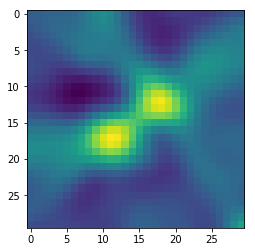

In [91]:
# Take some readings, subtract the base (<< scale and stuff todo) and reconstruct
sino = sinob5(read_all())
rel = base-sino
s, rec, blurred = recon(rel, 'rel.png', 'FBP', 1, False)
plt.imshow(blurred)

332


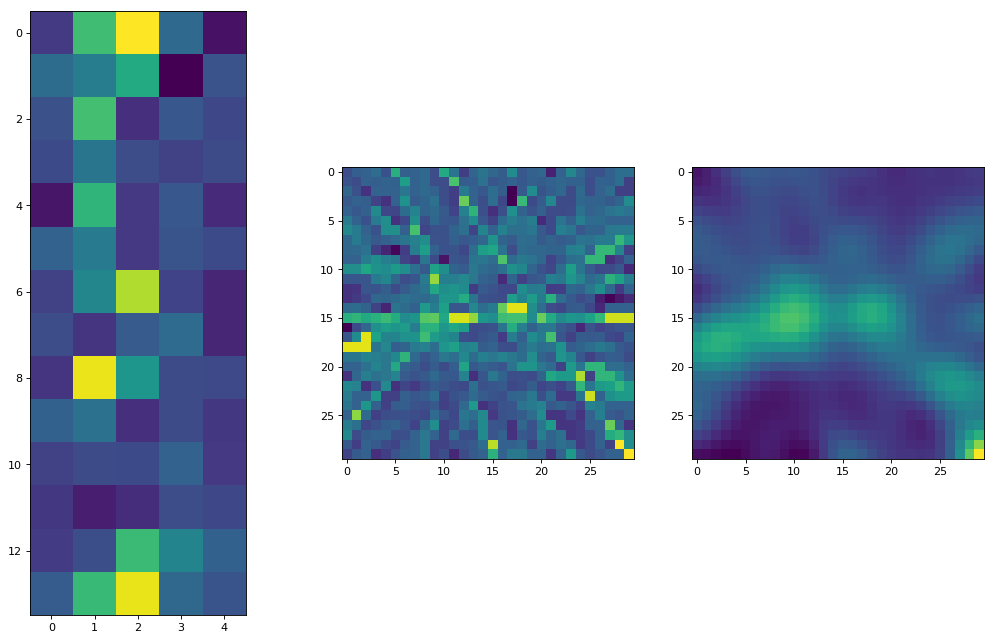

In [96]:
sino = sinob5(read_all())
rel = base-sino
s, rec, blurred = recon(rel, 'rel7.png', 'SIRT', 20, True)

# Simulation

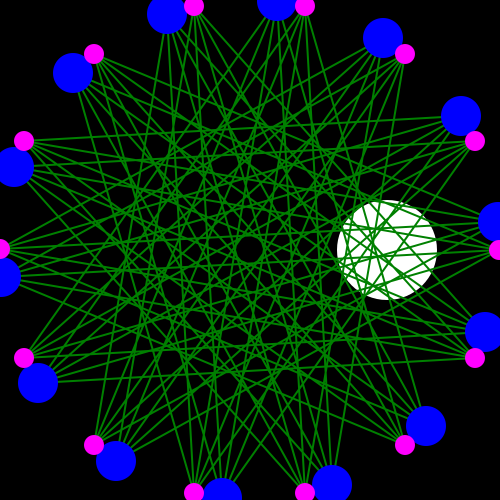

In [97]:
# This is basically what we're doing. 
fn = 'r14_sparse5.png'
Image(fn)

In [98]:
# <<<<<<<< Checkorder: DE or ED?
ds, es = [], []
for i in range(14):
    d = {
        'r':1, # Distance from center relative to furthest object
        'a':2*math.pi*(i+0.25)/14, #2*math.pi*i/8,
    }
    e = {
        'r':1, # Distance from center relative to furthest object
        'a':2*math.pi*(i)/14, #2*math.pi*i/8,
    }
    ds.append(d)
    es.append(e)

tis, tii, x, y = test_image(500, 500, 50, 0.55, 0)
    
paths = get_paths(tii, ds, es, 500, 500)

print(paths)    
print(sino5([i for i in range(14)]+paths))

[0, 0, 0, 0, 0, 12950, 23518, 25257, 20044, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22589, 25052, 15581, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24251, 20697, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24837, 9722, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 23559, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24898, 9880, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16558, 22849, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25361, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20596, 343, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23982, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23929, 15293, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 192, 25164, 17476, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22232, 25237, 17041, 0, 0, 0, 0, 0, 0, 0, 0]
[[12950 23518 25257 20044     0]
 [    0     0     0 22589 25052]
 [    0     0     0     0 24251]
 [    0     0     0     0 24837]
 [    0     0     0    48 23559]
 [    0     0     0 24898     0]
 [    0     0 16558  9880     0]
 [    0     0 22849     0     0]
 [    0 25361     0     0     0]
 [20596

In [99]:
sino = sino5([i for i in range(14)]+paths)

In [100]:
sino

array([[12950, 23518, 25257, 20044,     0],
       [    0,     0,     0, 22589, 25052],
       [    0,     0,     0,     0, 24251],
       [    0,     0,     0,     0, 24837],
       [    0,     0,     0,    48, 23559],
       [    0,     0,     0, 24898,     0],
       [    0,     0, 16558,  9880,     0],
       [    0,     0, 22849,     0,     0],
       [    0, 25361,     0,     0,     0],
       [20596,   343,     0,     0,     0],
       [23982,     0,     0,     0,     0],
       [15293,     0,     0,     0,     0],
       [17476,     0,     0,     0,     0],
       [25237, 17041,     0,     0,     0]])

49693


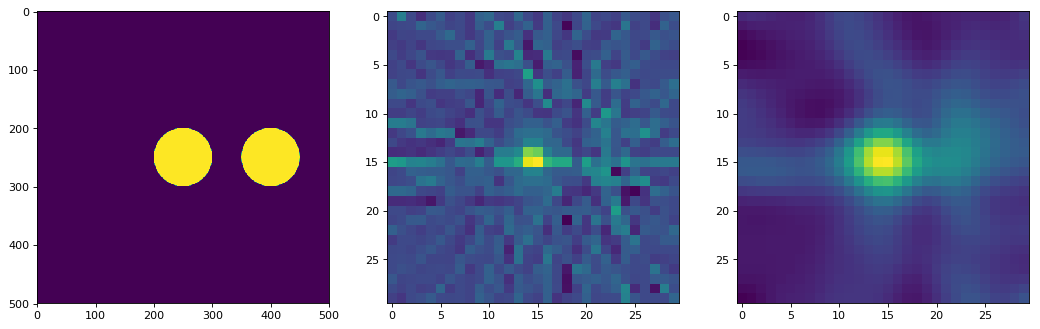

In [102]:
# <<<<<<<< Checkorder: DE or ED?
ds, es = [], []
for i in range(14):
    d = {
        'r':1, # Distance from center relative to furthest object
        'a':-2*math.pi*(i+0.25)/14, #2*math.pi*i/8,
    }
    e = {
        'r':1, # Distance from center relative to furthest object
        'a':-2*math.pi*(i)/14, #2*math.pi*i/8,
    }
    ds.append(d)
    es.append(e)

nviews = 14
ndetectors = 5
nvdetectors = 5

IMSIZE = 30
R = IMSIZE/2
D = IMSIZE/2

# Transforming from a round fan-beam to a fan-flat projection (See diagram)
beta = np.linspace(-math.pi/2 + 2*5*math.pi/14, -math.pi/2 + 2*10*math.pi/14, ndetectors)
alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta])
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

tau_new = np.linspace(min(tau), max(tau), nvdetectors)

vol_geom = astra.create_vol_geom(IMSIZE, IMSIZE)
angles = np.linspace(0,2*math.pi,nviews);
d_size = (tau[-1]-tau[0])/nvdetectors
proj_geom= astra.create_proj_geom('fanflat', d_size, nvdetectors, angles, D, R);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)


for i in range(1):
    
    tis, tii, x, y = test_image(500, 500, 50, 0.6, 0)
    tis, tii2, x, y = test_image(500, 500, 50, abs(0.3*math.sin(2*math.pi*i/14)), 0)
    tii = tii + tii2

    paths = get_paths(tii, ds, es, 500, 500)

    sino = sino5([i for i in range(14)]+paths)
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, sino)
    
    # Plotting sinogram - new (transformed) set of readings
    plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(tii) #<< Set title

    # Doing the reconstruction, in this case with FBP

    rec_id = astra.data2d.create('-vol', vol_geom)

    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = proj_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    astra.algorithm.run(alg_id, 1)

    # Get the result
    rec = astra.data2d.get(rec_id)
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(rec.T)
    norm_rec = rec.T/(np.amax(np.abs(rec)))
    blurred = skimage.filters.gaussian(norm_rec, 2)
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(blurred)
    
    plt.savefig('r14_anim'+str(i) + '.png')
    print(max(sino.flatten()))

# Machine learning for position inference

In [ ]:
ds, es = [], []
for i in range(14):
    d = {
        'r':1, # Distance from center relative to furthest object
        'a':2*math.pi*(i+0.25)/14, #2*math.pi*i/8,
    }
    e = {
        'r':1, # Distance from center relative to furthest object
        'a':2*math.pi*(i)/14, #2*math.pi*i/8,
    }
    ds.append(d)
    es.append(e)

tis, tii, x, y = test_image(500, 500, 50, 0.55, 0)
    
paths = get_paths(tii, ds, es, 500, 500)

print(paths)    
print(sino5([i for i in range(14)]+paths))

In [ ]:
# Generate training data (sparse paths and full)

X = []
Xs = []
pos = []

for i in range(1500):
    r = random.random()*0.5 # Get whole shape within circle
    rand = random.choice([0, 1, 2, 3])
    a = rand*math.pi/2 + (random.random()*math.pi/2 - math.pi/4)
    tis, tii, x, y = test_image(500, 500, 20, r*math.cos(a), r*math.sin(a))
    path = get_paths(tii, ds, es, 500, 500)
    for p in range(len(path)):
        path[p] += random.random()*100
        
    X.append(path)
    Xs.append(sino5([i for i in range(14)]+path).flatten())
    
    pos.append((r*math.cos(a), r*math.sin(a))) # x, y pos because arb


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, pos)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
mlpc.fit(X_train, y_train)

pred = mlpc.predict(X_test)

xe = []
ye = []
for i in range(len(pred)):
    p = pred[i]
    a = y_test[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))
    
print("mean of errors:",np.asarray(ye).mean())
print("Standard deviation of errors:",np.asarray(ye).std())
# sns.set(color_codes=True)
ax = sns.distplot(ye);
ax.set_xlabel('Error relative to radius')
ax.set_ylabel('Occurence')
ax.set_ylim((0,25))
ax.set_xlim((0,0.4))
# plt.savefig('ring_of_16_error_distribution_16.png')

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, pos)

regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

xe = []
ye = []
for i in range(len(pred)):
    p = pred[i]
    a = y_test[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))
    
print("mean of errors:",np.asarray(ye).mean())
print("Standard deviation of errors:",np.asarray(ye).std())
# sns.set(color_codes=True)
ax = sns.distplot(ye);
ax.set_xlabel('Error relative to radius')
ax.set_ylabel('Occurence')
ax.set_ylim((0,25))
ax.set_xlim((0,0.4))

In [ ]:
# Now with sparse paths
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(Xs, pos)

regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

xe = []
ye = []
for i in range(len(pred)):
    p = pred[i]
    a = y_test[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))
    
print("mean of errors:",np.asarray(ye).mean())
print("Standard deviation of errors:",np.asarray(ye).std())
# sns.set(color_codes=True)
ax = sns.distplot(ye);
ax.set_xlabel('Error relative to radius')
ax.set_ylabel('Occurence')
ax.set_ylim((0,25))
ax.set_xlim((0,0.4))

In [ ]:
pred = regr.predict(Xs)
xe = []
ye = []
xp = []
yp = []
for i in range(len(pred)):
    p = pred[i]
    a = pos[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))
    xp.append(p[0])
    yp.append(p[1])
plt.scatter(xp, yp, c=ye)
plt.colorbar()

In [ ]:
# trying again with the other arrangement

In [ ]:
ds, es = [], []
for i in range(14):
    d = {
        'r':1, # Distance from center relative to furthest object
        'a':2*math.pi*(i+0.5)/14, # <<<<<<<<< changed to this, now evenly spaced
    }
    e = {
        'r':1, # Distance from center relative to furthest object
        'a':2*math.pi*(i)/14, #2*math.pi*i/8,
    }
    ds.append(d)
    es.append(e)
    
# Generate training data (sparse paths and full)

X2 = []
X2s = []
pos2 = []

for i in range(1500):
    r = random.random()*0.5 # Get whole shape within circle
    rand = random.choice([0, 1, 2, 3])
    a = rand*math.pi/2 + (random.random()*math.pi/2 - math.pi/4)
    tis, tii, x, y = test_image(500, 500, 20, r*math.cos(a), r*math.sin(a))
    path = get_paths(tii, ds, es, 500, 500)
    for p in range(len(path)):
        path[p] += random.random()*100
        
    X2.append(path)
    X2s.append(sino5([i for i in range(14)]+path).flatten())
    
    pos2.append((r*math.cos(a), r*math.sin(a))) # x, y pos because arb

In [ ]:
# Now with sparse paths
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X2s, pos2)

regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

xe = []
ye = []
for i in range(len(pred)):
    p = pred[i]
    a = y_test[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))
    
print("mean of errors:",np.asarray(ye).mean())
print("Standard deviation of errors:",np.asarray(ye).std())
# sns.set(color_codes=True)
ax = sns.distplot(ye);
ax.set_xlabel('Error relative to radius')
ax.set_ylabel('Occurence')
ax.set_ylim((0,25))
ax.set_xlim((0,0.4))

In [ ]:
regr.predict(X2s)

In [ ]:
pred = regr.predict(X2s)
xe = []
ye = []
xp = []
yp = []
for i in range(len(pred)):
    p = pred[i]
    a = pos2[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))
    xp.append(p[0])
    yp.append(p[1])
plt.scatter(xp, yp, c=ye)
plt.colorbar()

 And doing it more thoroughly

In [ ]:
X_off = [] # offset

X_reg = [] # Regular

# Offset
ods, oes = [], []
for i in range(14):
    d = {
        'r':1, # Distance from center relative to furthest object
        'a':2*math.pi*(i+0.25)/14, #2*math.pi*i/8,
    }
    e = {
        'r':1, # Distance from center relative to furthest object
        'a':2*math.pi*(i)/14, #2*math.pi*i/8,
    }
    ods.append(d)
    oes.append(e)
    
# Regular
ds, es = [], []
for i in range(14):
    d = {
        'r':1, # Distance from center relative to furthest object
        'a':2*math.pi*(i+0.5)/14, # <<<<<<<<< changed to this, now evenly spaced
    }
    e = {
        'r':1, # Distance from center relative to furthest object
        'a':2*math.pi*(i)/14, #2*math.pi*i/8,
    }
    ds.append(d)
    es.append(e)
    
# The Y values
pos = []

# Training data
for i in range(5000):
#     r = random.random()*0.5 # Get whole shape within circle
#     a = random.random()*math.pi*2
    xp, yp = random.random()*60, random.random()*60
    tis, tii, x, y = test_image(500, 500, 20, (xp-30)/60, (yp-30)/60)
    
    path = get_paths(tii, ods, oes, 500, 500)
    for p in range(len(path)):
        path[p] += random.random()*100
        
    X_off.append(path) # Just path for fulll info case sino5([i for i in range(14)]+path).flatten()
    
    path = get_paths(tii, ds, es, 500, 500)
    for p in range(len(path)):
        path[p] += random.random()*100
        
    X_reg.append(path) # Just path for fulll info case
    
    pos.append(((xp-30)/60, (yp-30)/60)) # x, y pos because arb


In [ ]:
# Testing data
Xt_off = []
Xt_reg = []
pos_t = []

for xp in range(60):
    for yp in range(60):
        tis, tii, x, y = test_image(500, 500, 20, (xp-30)/60, (yp-30)/60)

        path = get_paths(tii, ods, oes, 500, 500)
        for p in range(len(path)):
            path[p] += random.random()*100

        Xt_off.append(path) # Just path for fulll info case sino5([i for i in range(14)]+path).flatten()

        path = get_paths(tii, ds, es, 500, 500)
        for p in range(len(path)):
            path[p] += random.random()*100

        Xt_reg.append(path) # Just path for fulll info case

        pos_t.append(((xp-30)/60, (yp-30)/60)) # x, y pos because arb

In [ ]:
regr1 = RandomForestRegressor(max_depth=5, random_state=0)
regr1.fit(X_off, pos)
pred1 = regr1.predict(Xt_off)

regr2 = RandomForestRegressor(max_depth=5, random_state=0)
regr2.fit(X_reg, pos)
pred2 = regr2.predict(Xt_reg)

In [ ]:
xe = []
ye = []
xp = []
yp = []
error = []
for i in range(len(pred1)):
    p = pred1[i]
    a = pos_t[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))
    xp.append(p[0])
    yp.append(p[1])
    error.append((abs(p[0]-a[0])**2 + abs(p[1]-a[1])**2)**0.5)
    
x = [p[0] for p in pos_t]
y = [p[1] for p in pos_t]
plt.scatter(x, y, c=np.asarray(error).clip(0, 0.5))
plt.colorbar()

In [ ]:
xe = []
ye = []
xp = []
yp = []
error = []
for i in range(len(pred2)):
    p = pred2[i]
    a = pos_t[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))
    xp.append(p[0])
    yp.append(p[1])
    error.append((abs(p[0]-a[0])**2 + abs(p[1]-a[1])**2)**0.5)
    
x = [p[0] for p in pos_t]
y = [p[1] for p in pos_t]
plt.scatter(x, y, c=np.asarray(error).clip(0, 0.5))
plt.colorbar()

In [ ]:
r = random.random()*0.5 # Get whole shape within circle
a = random.random()*math.pi*2
tis, tii, x, y = test_image(500, 500, 20, r*math.cos(a), r*math.sin(a))
plt.imshow(tii)

# Recording a movie (can go really fast)

In [9]:
ser.read_all()

b''

In [10]:
base = sinob5(read_all())

Done recording
318
318
318
318
318
318
318
318
318
318
318
318
318
318
318
318
318
318
318
318


/home/jonathan/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


318
318
318
318
318
318
318
318
318
318


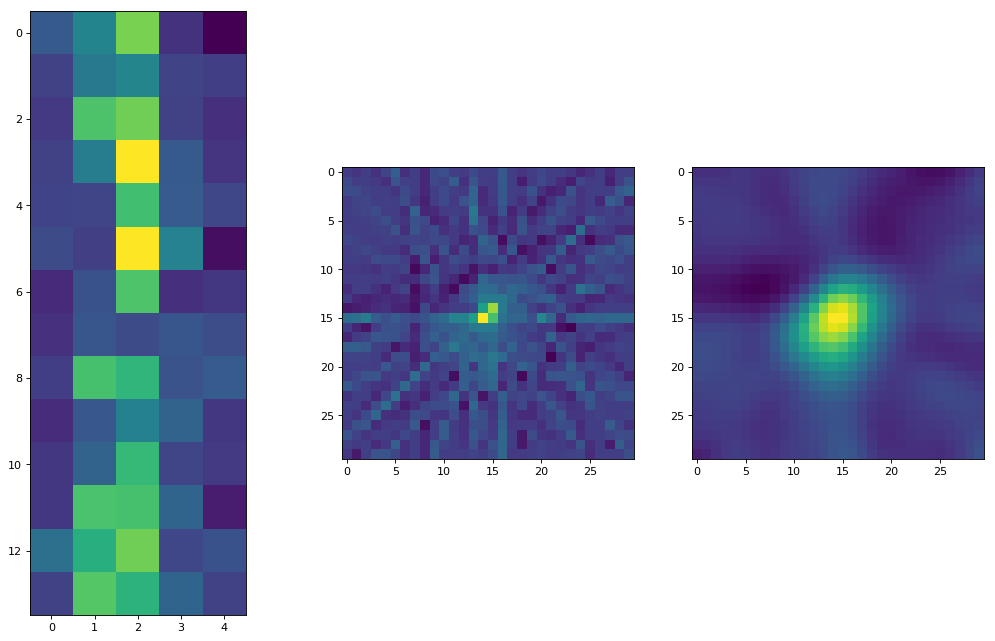

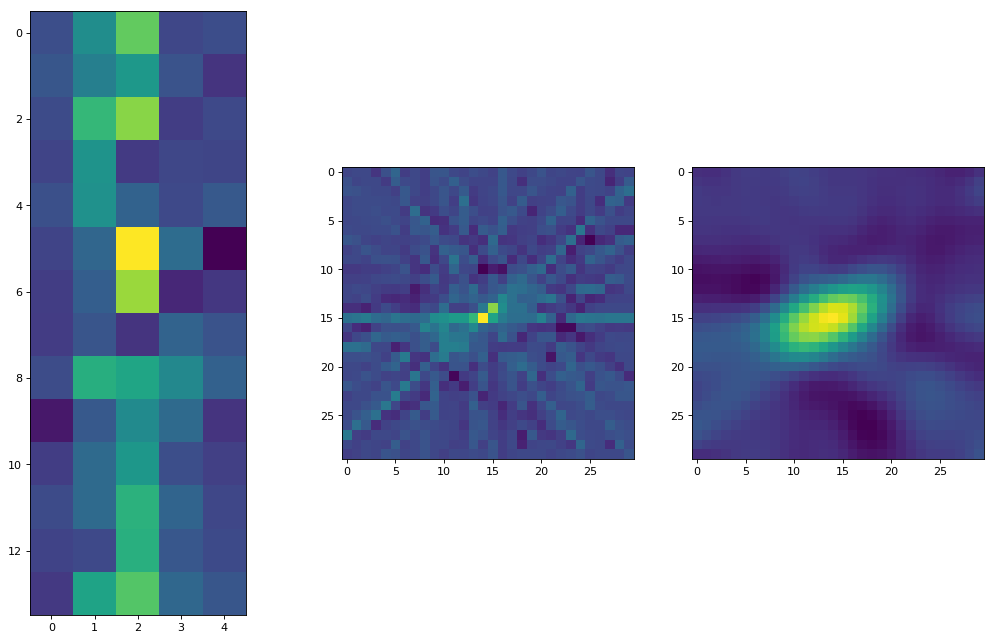

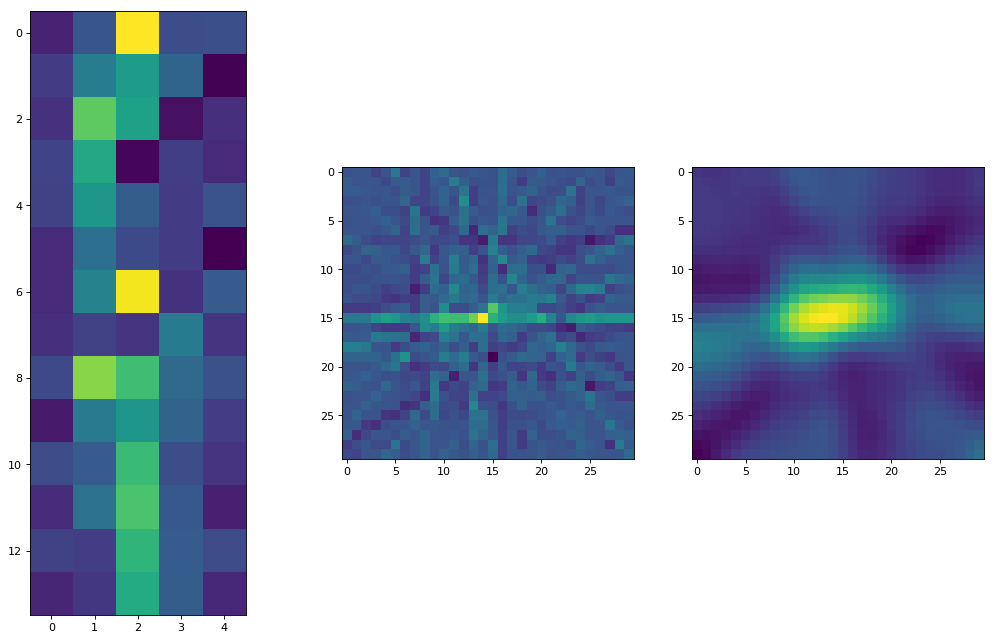

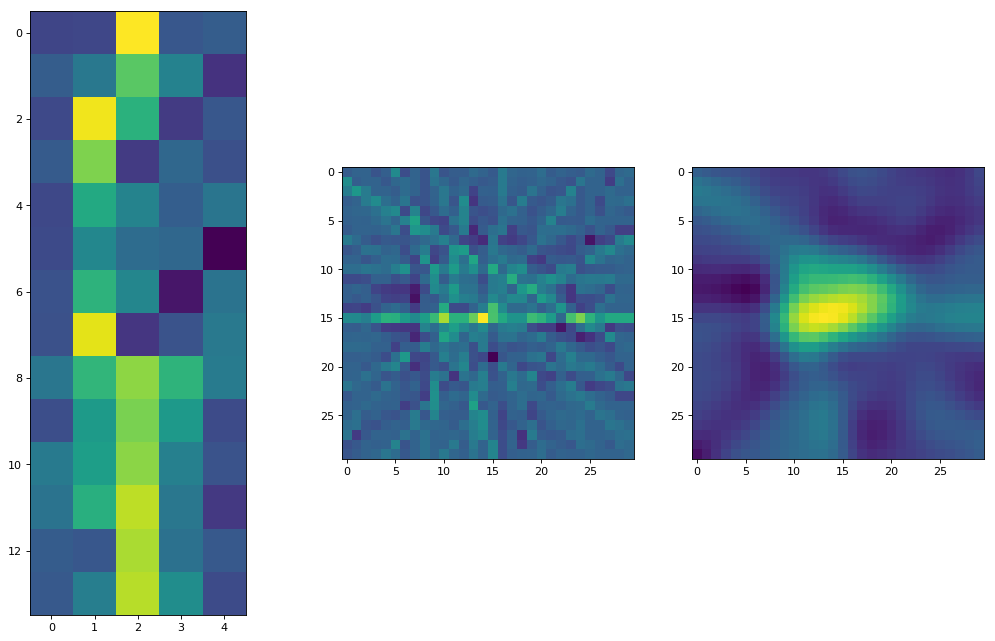

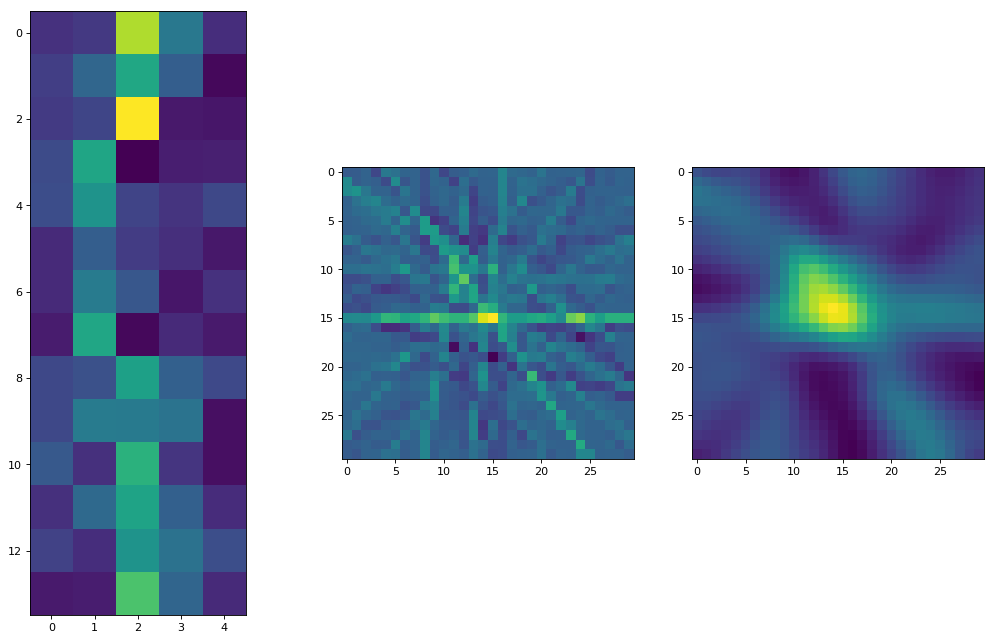

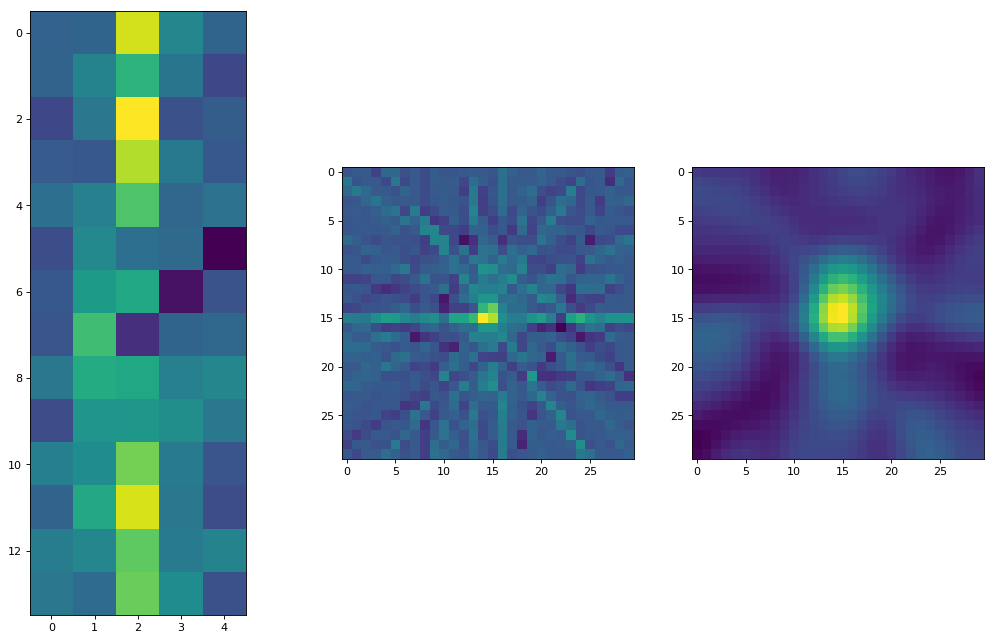

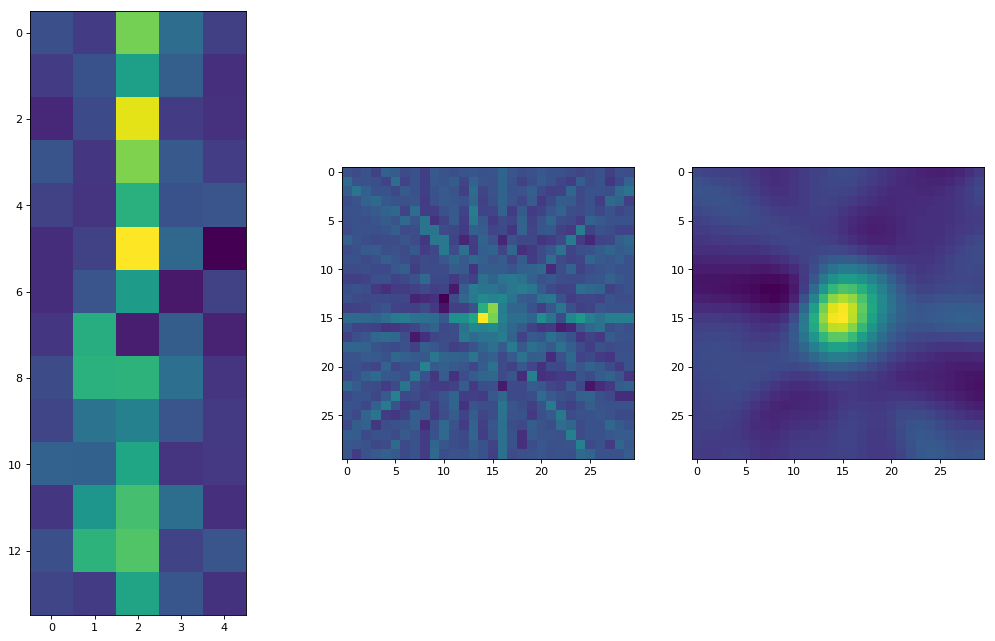

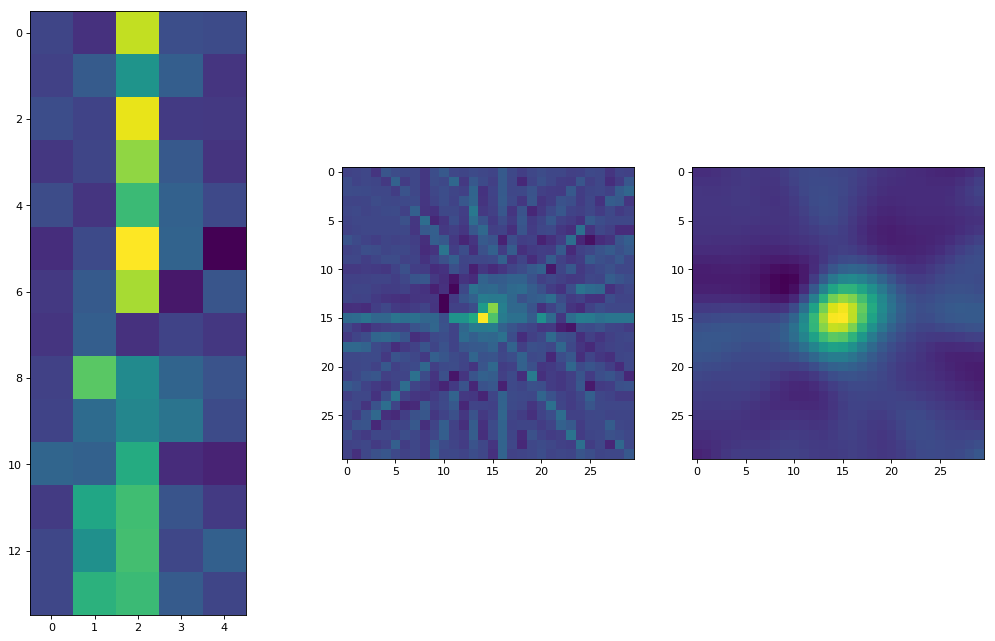

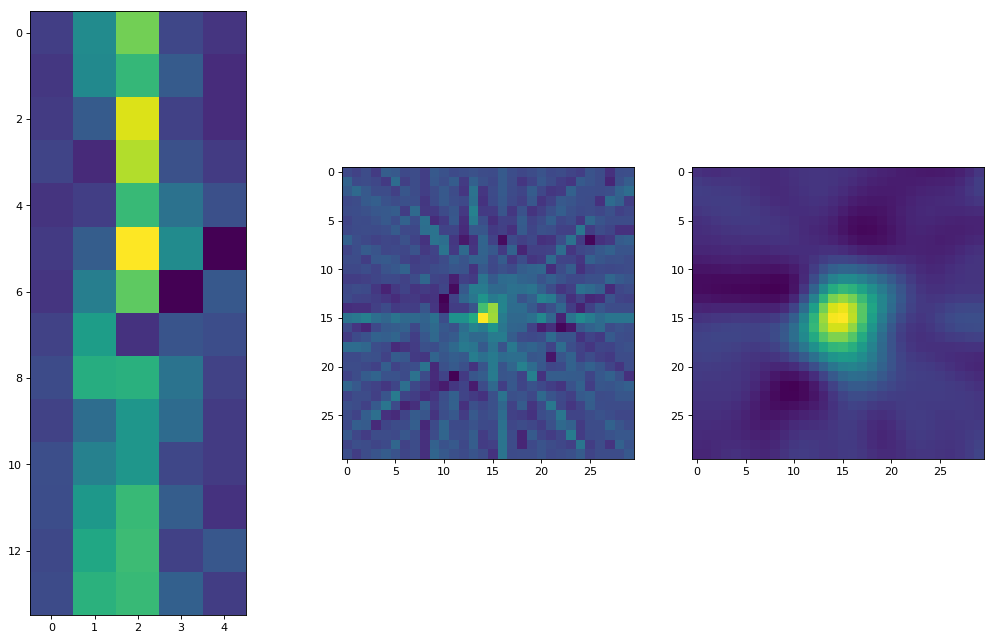

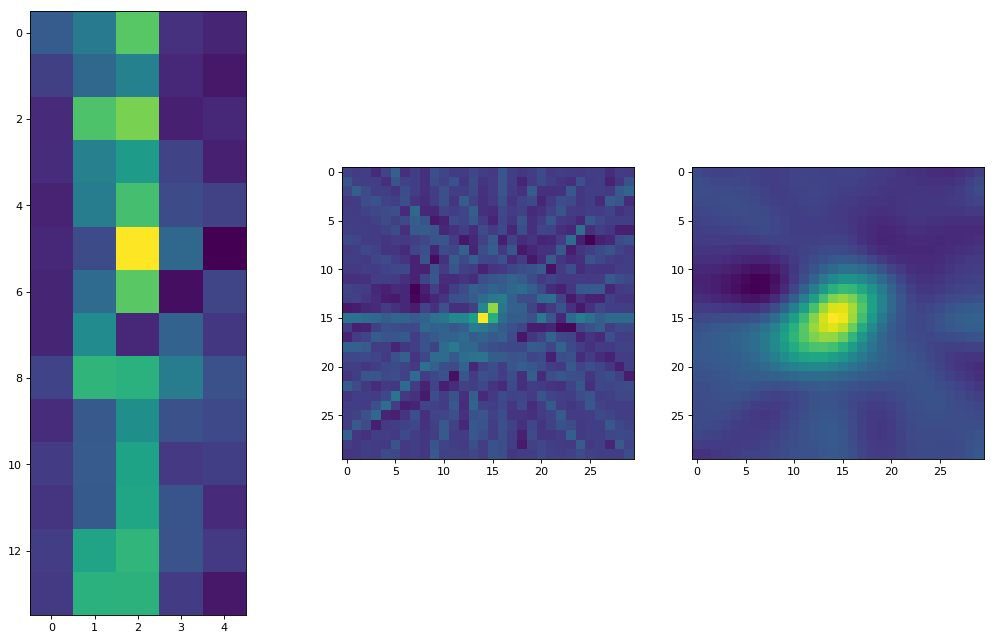

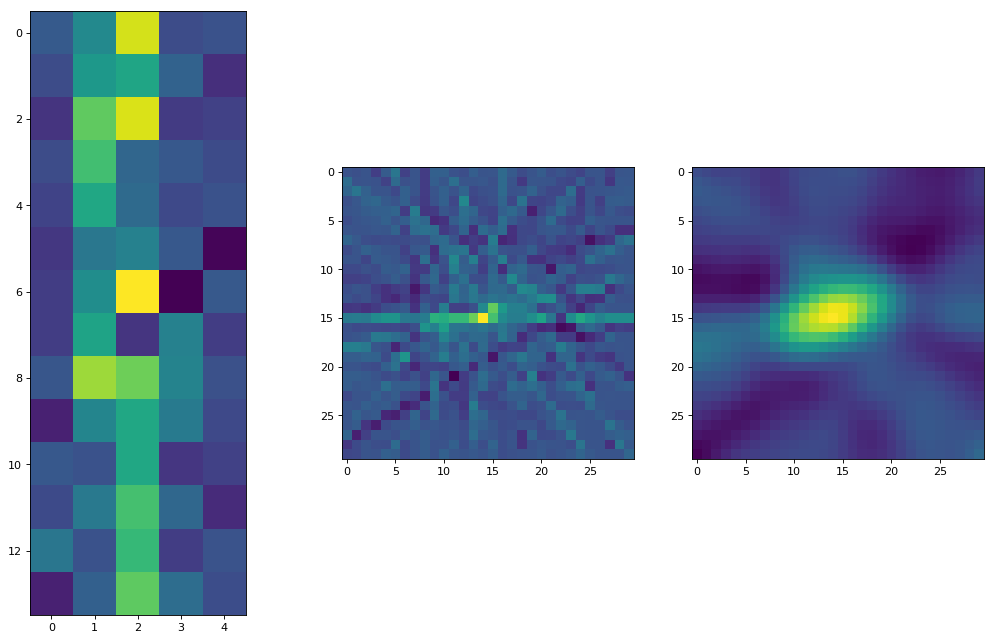

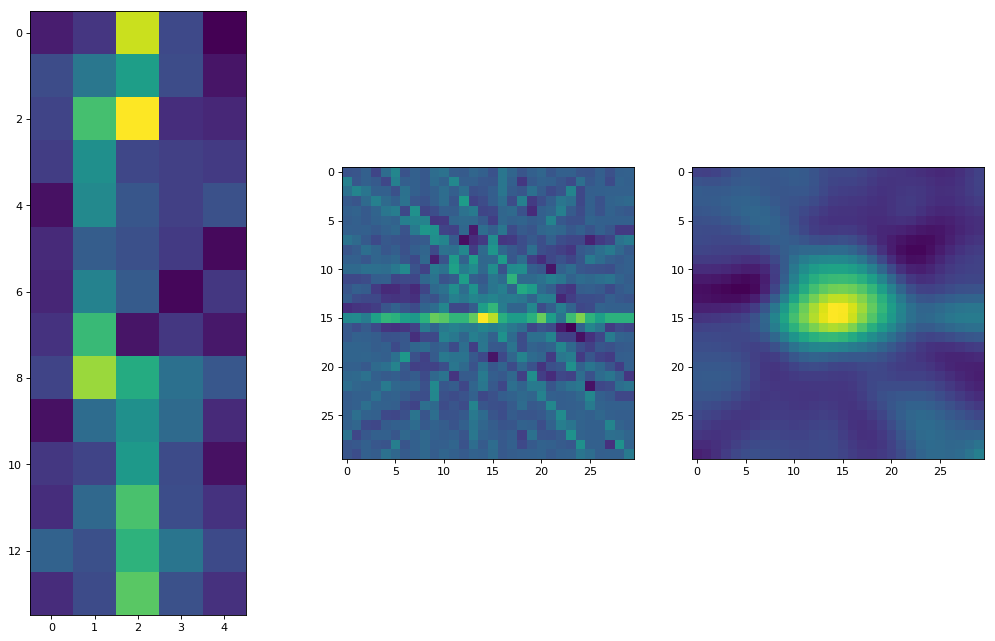

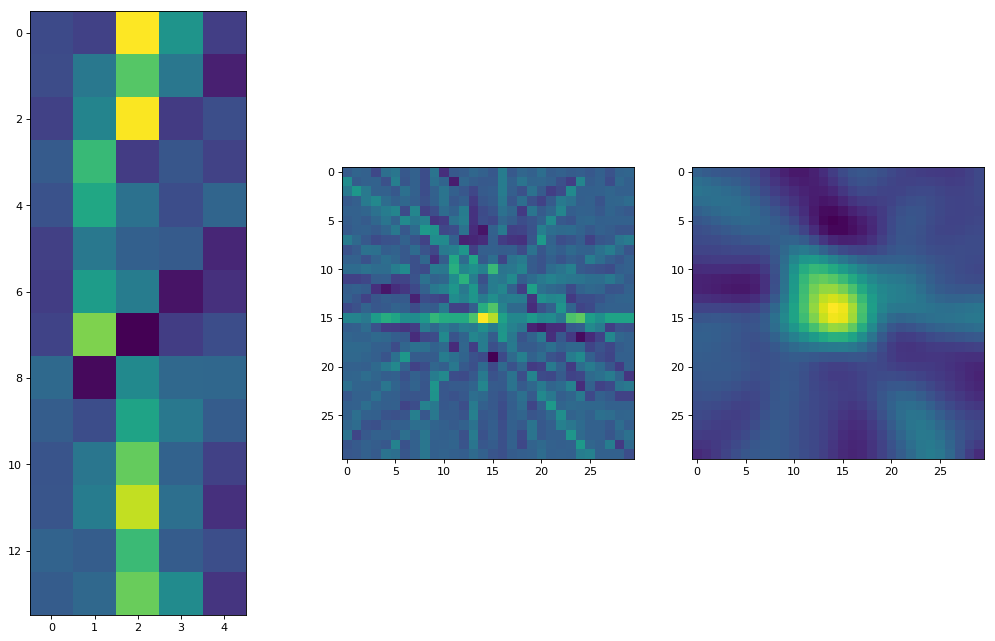

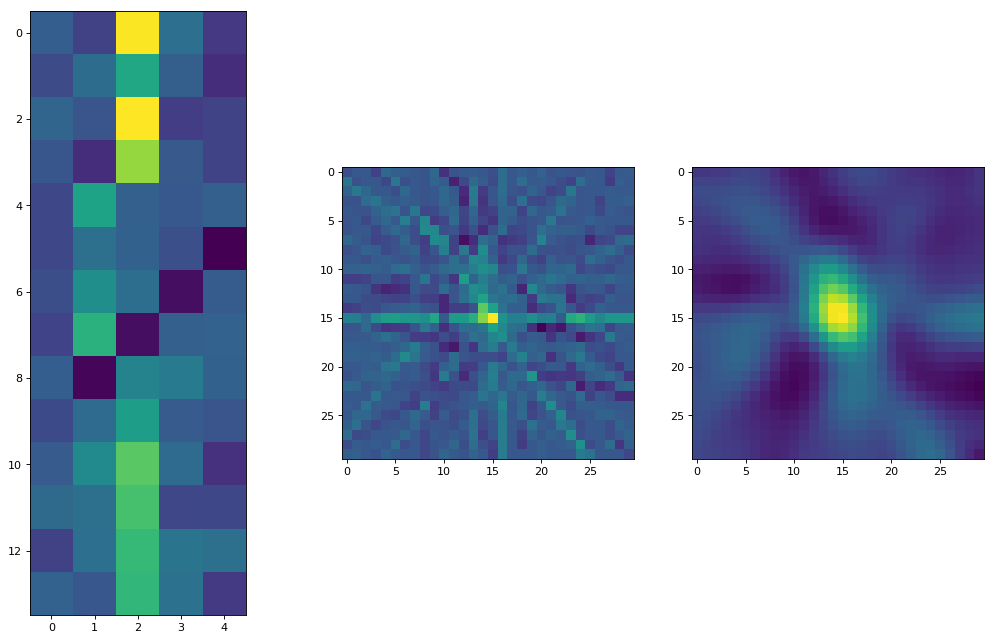

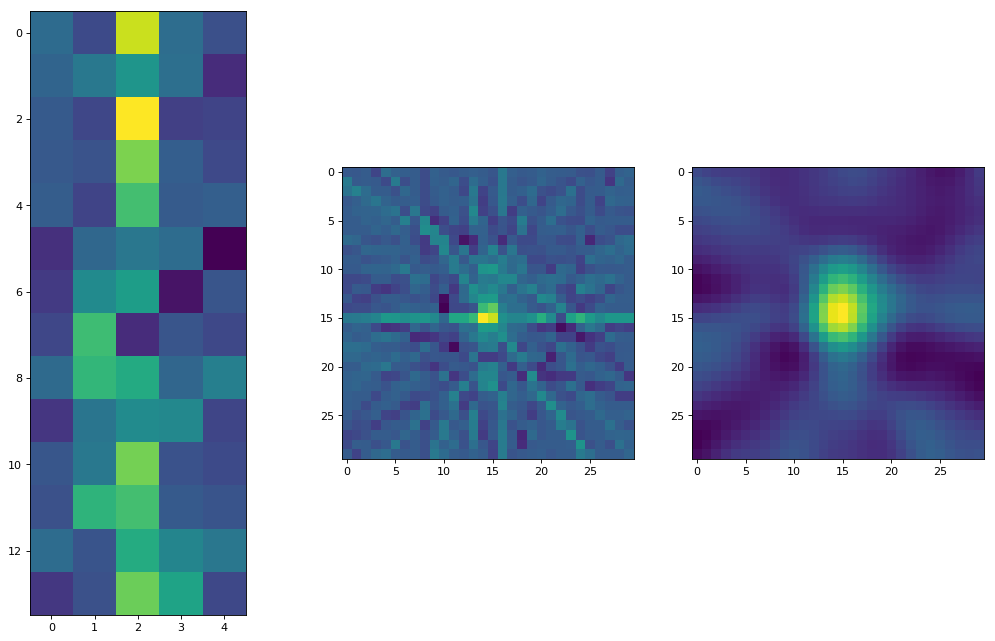

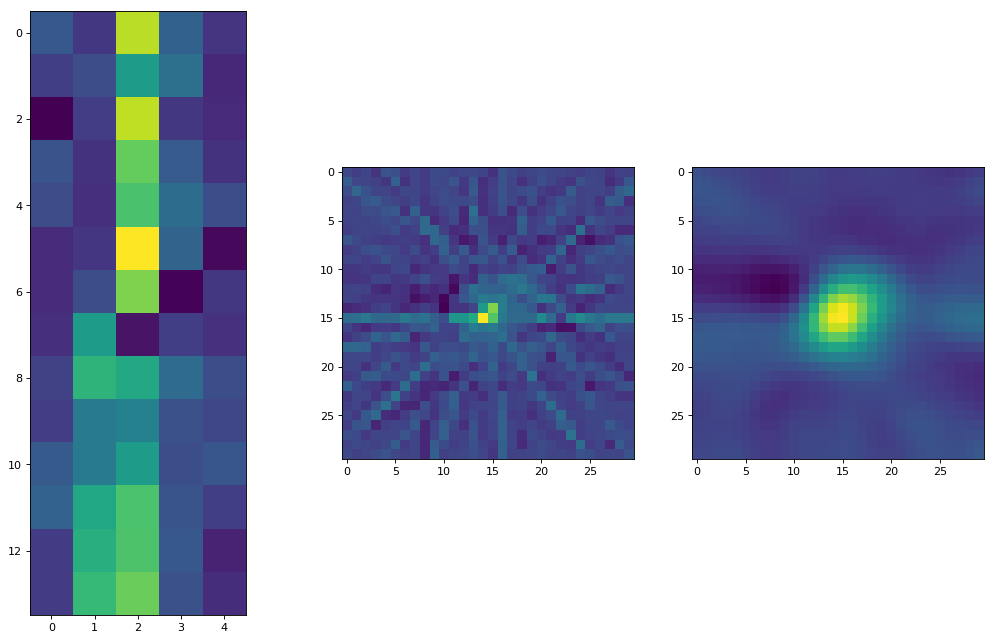

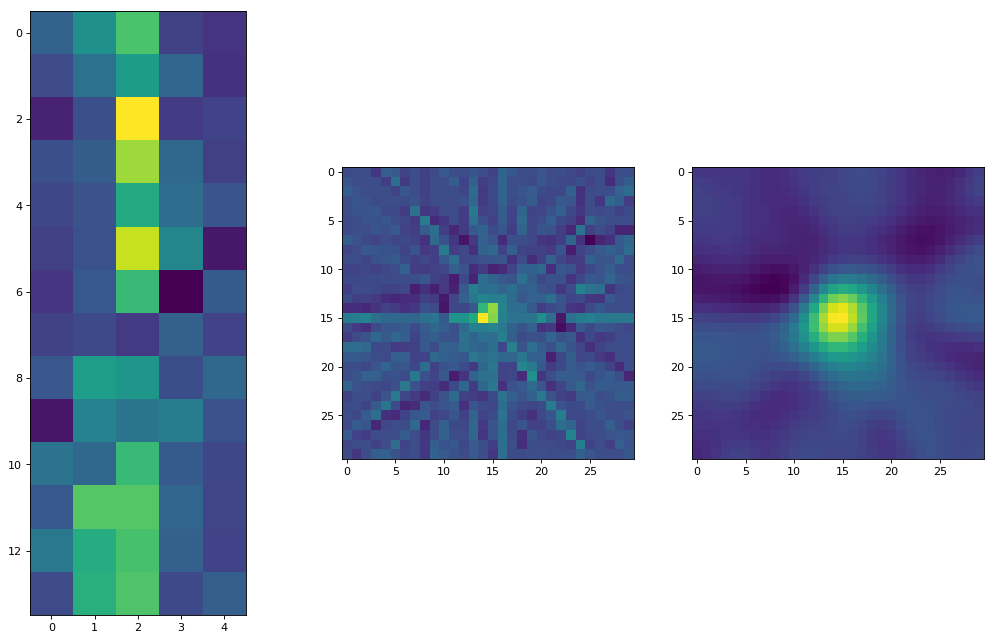

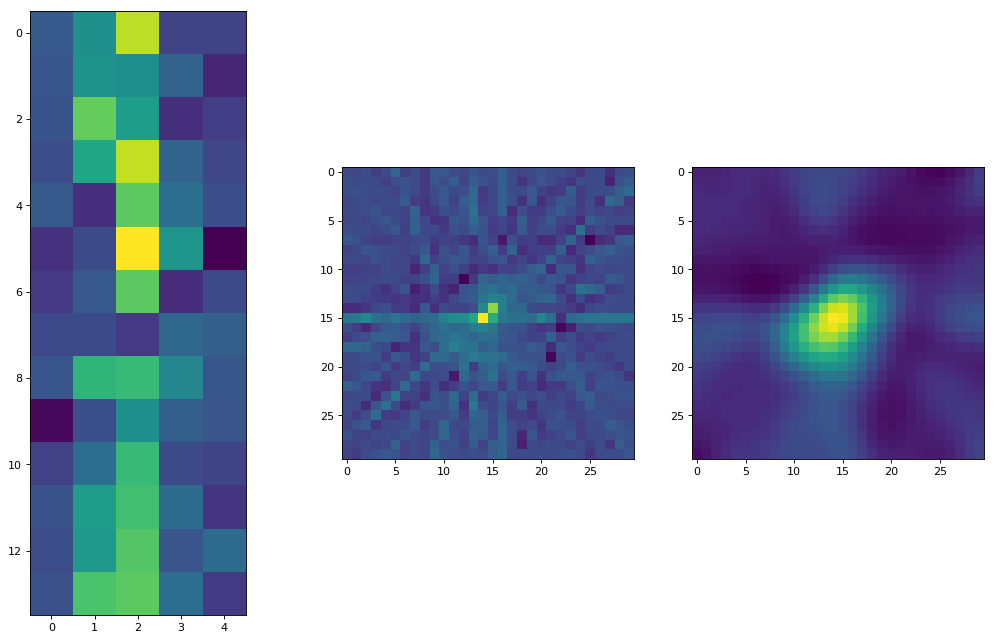

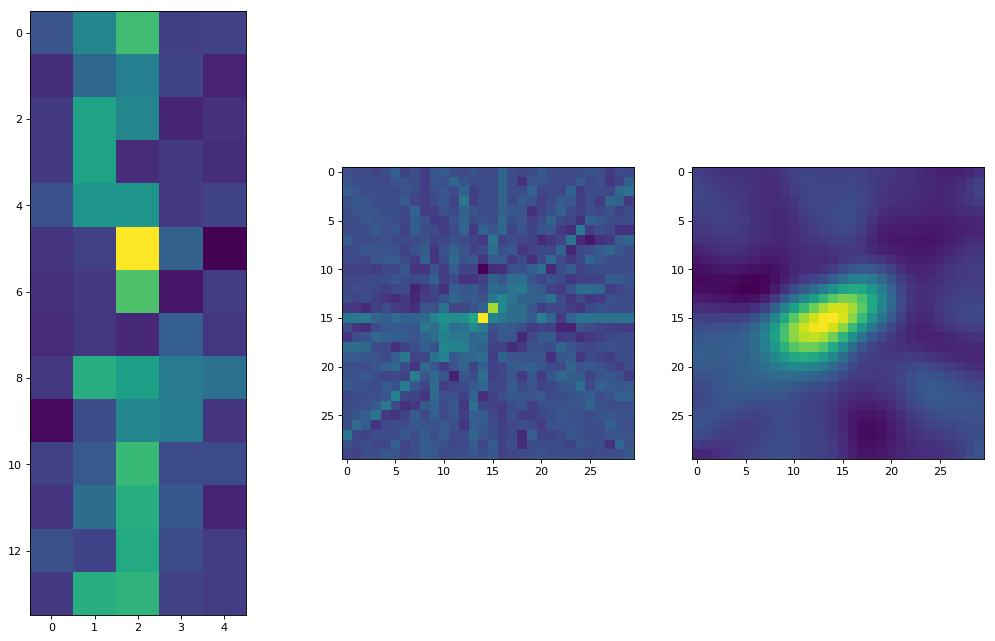

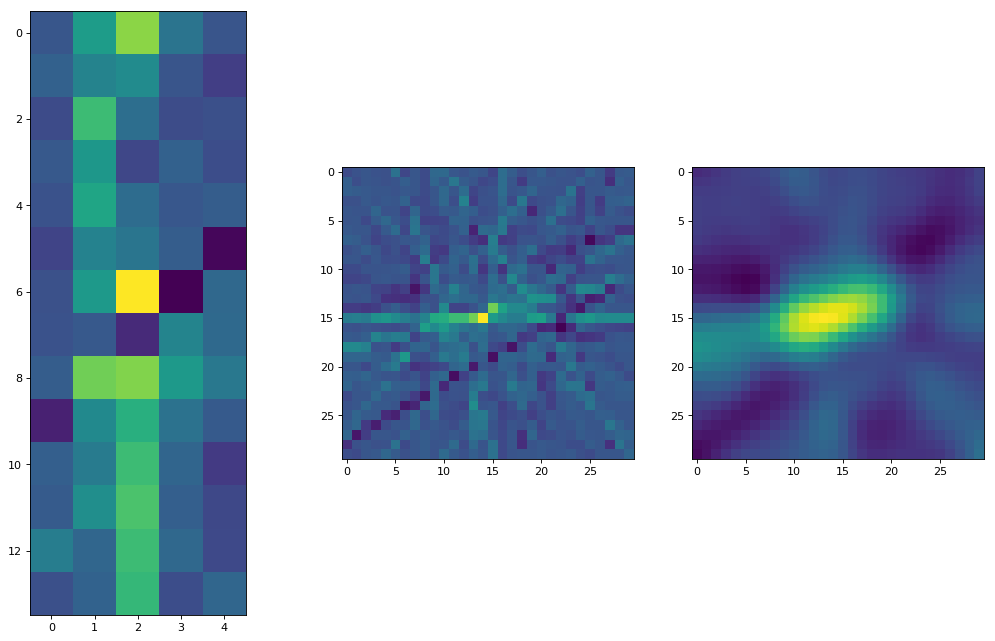

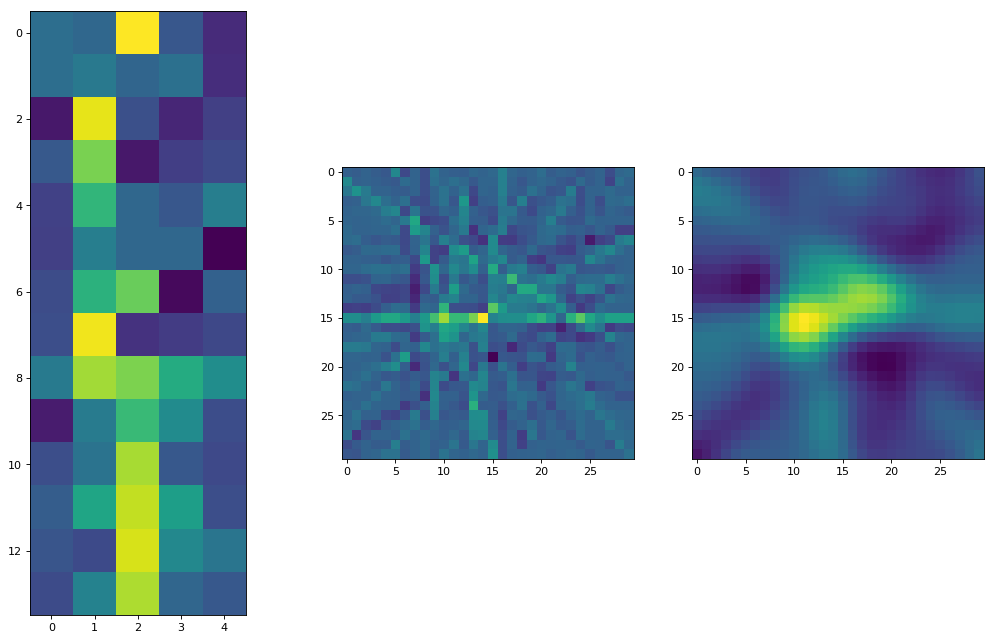

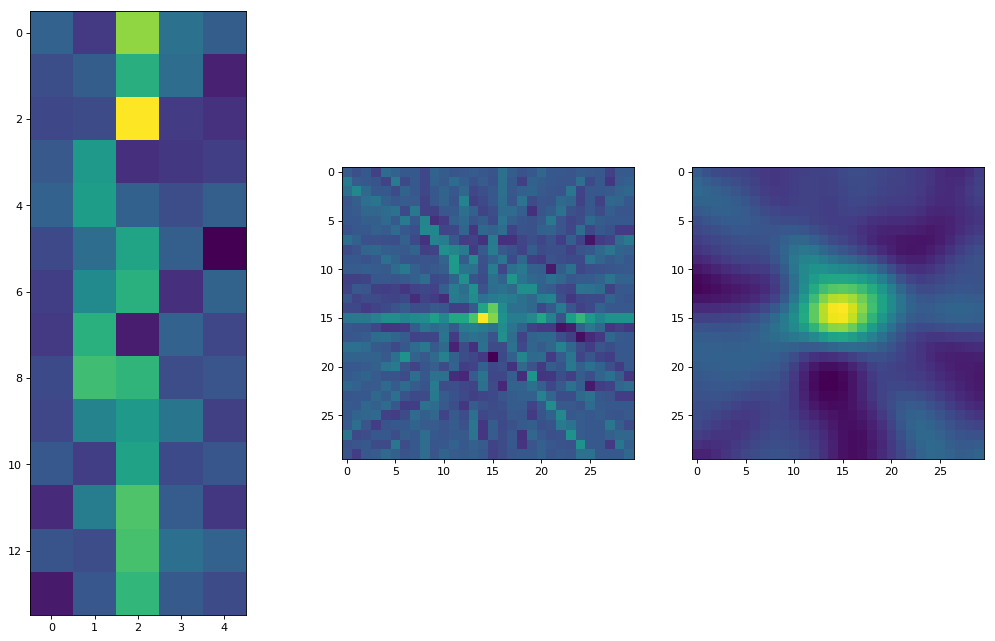

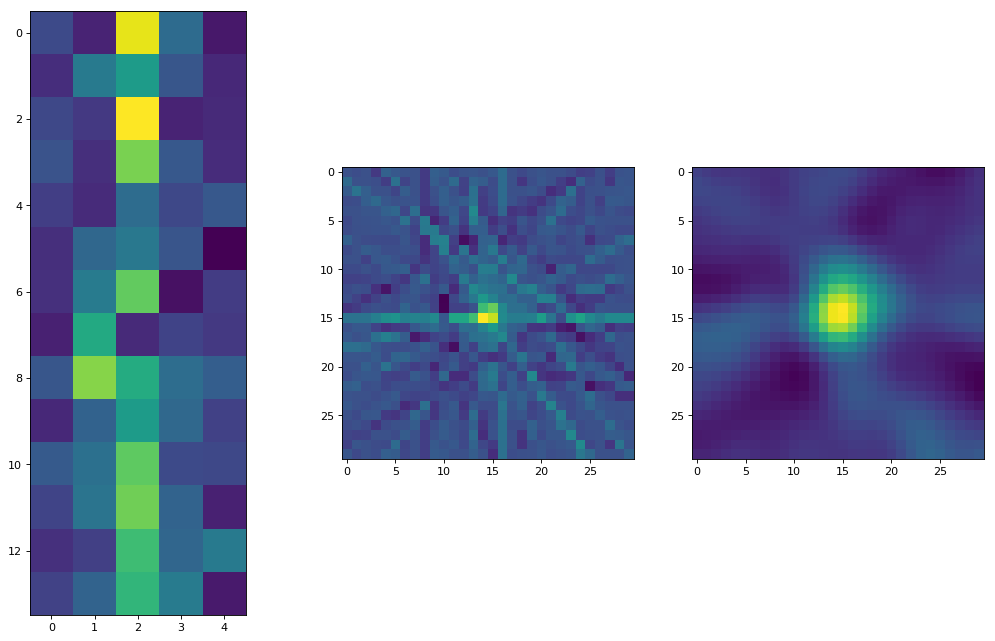

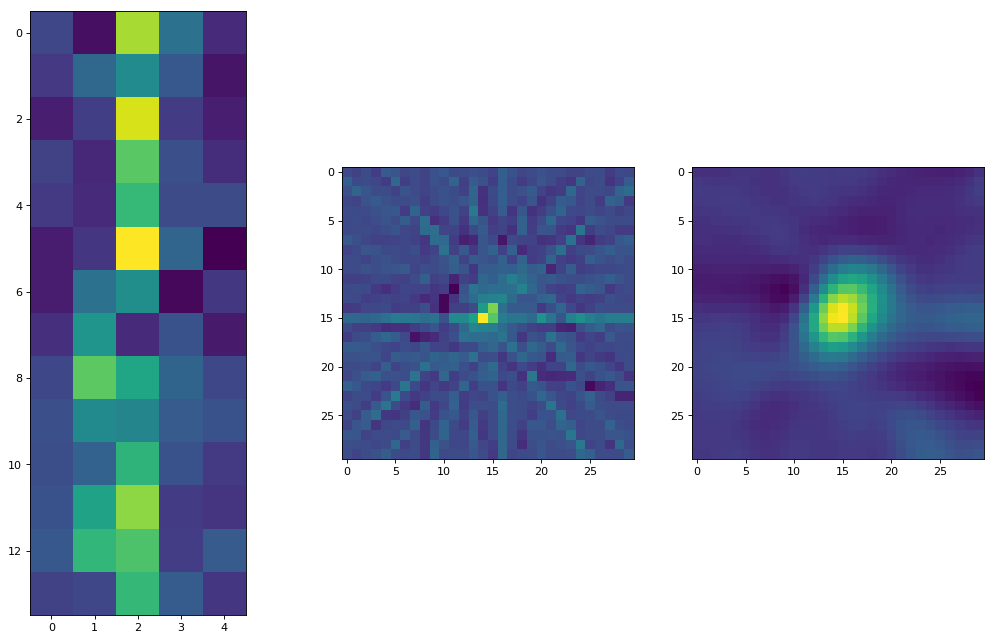

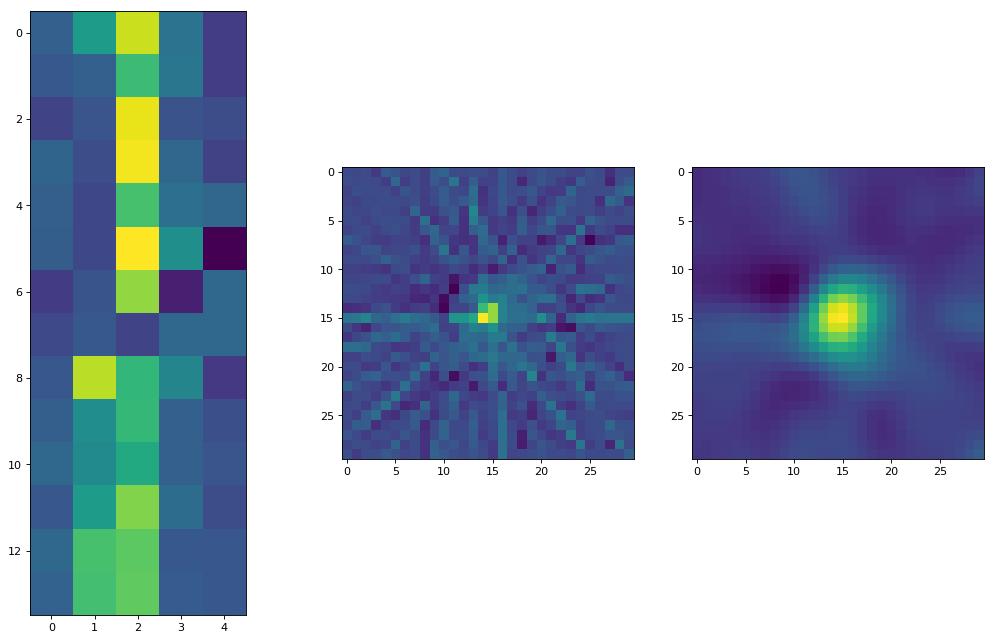

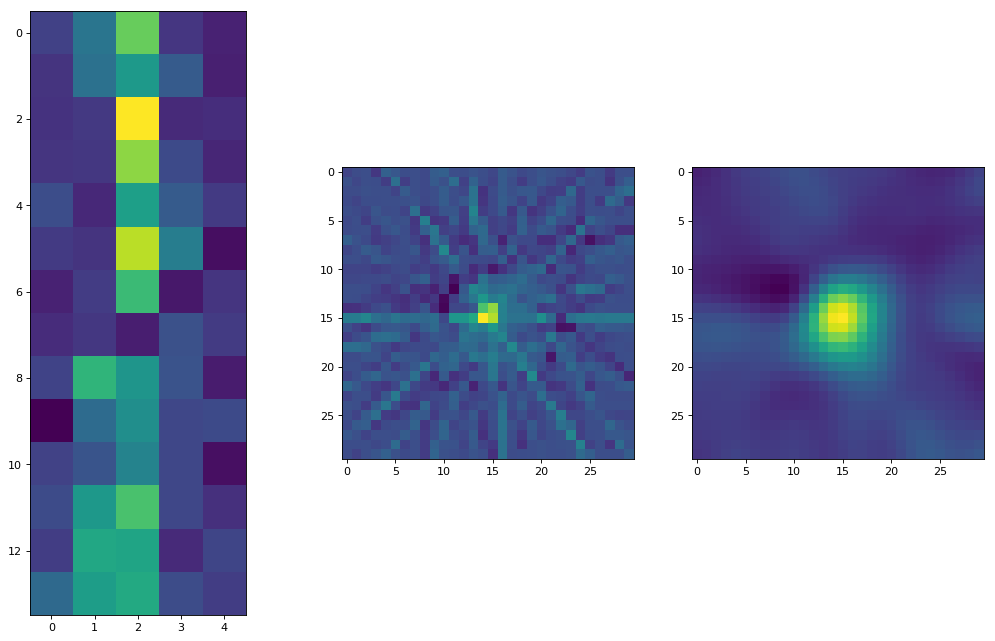

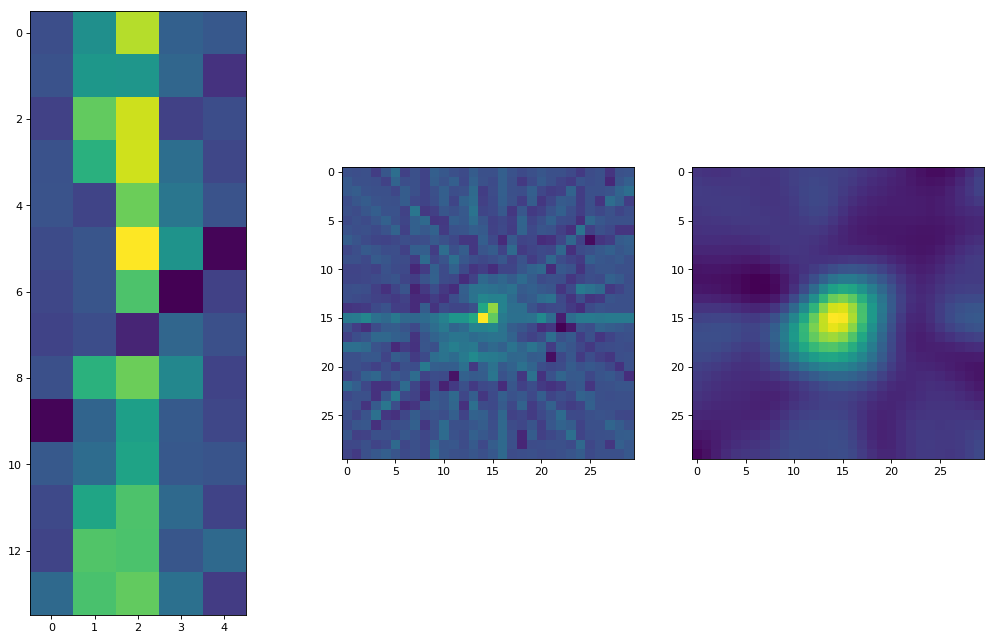

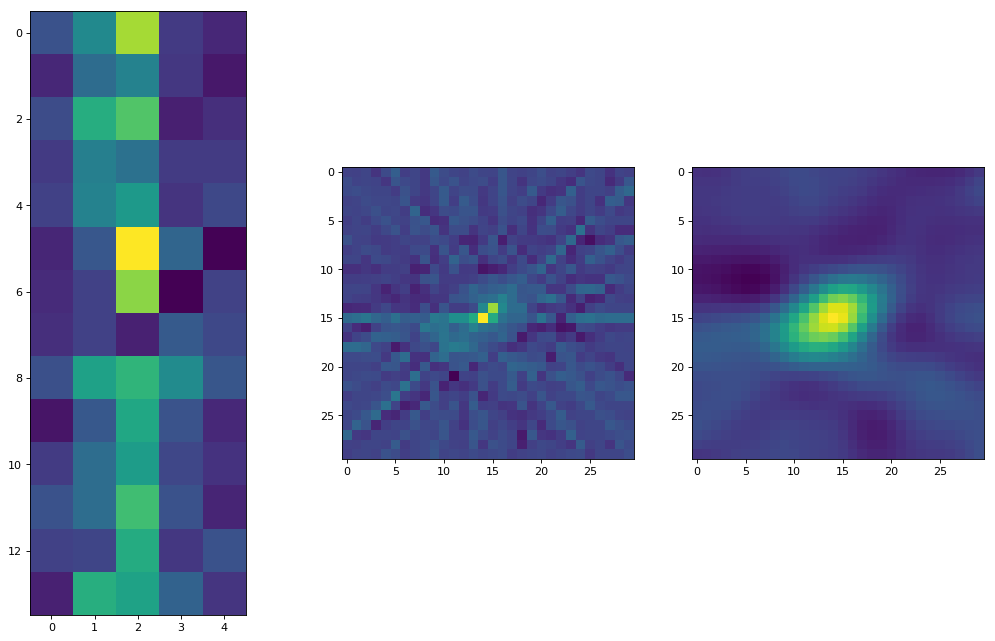

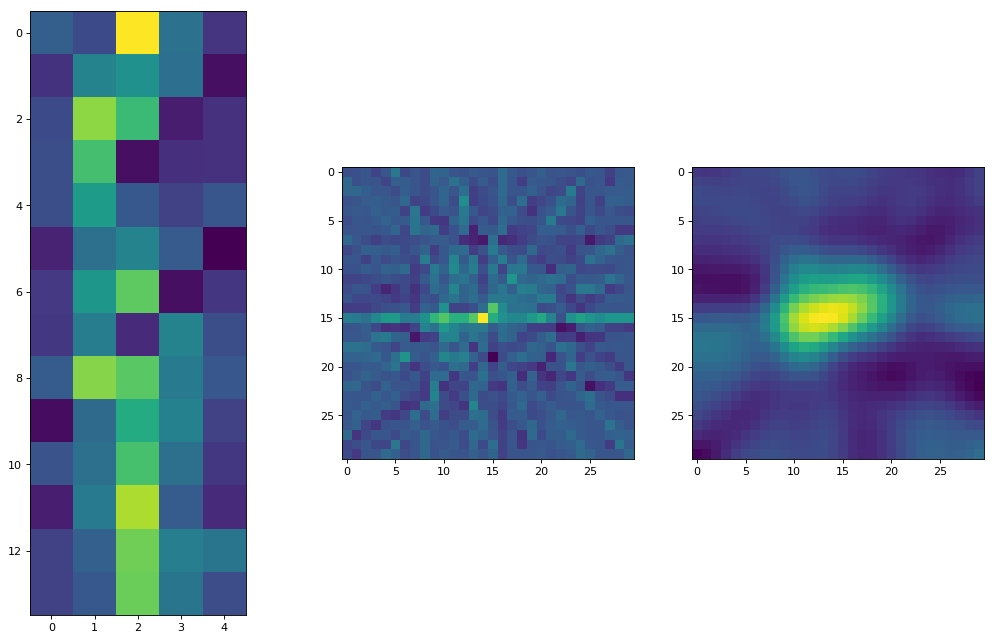

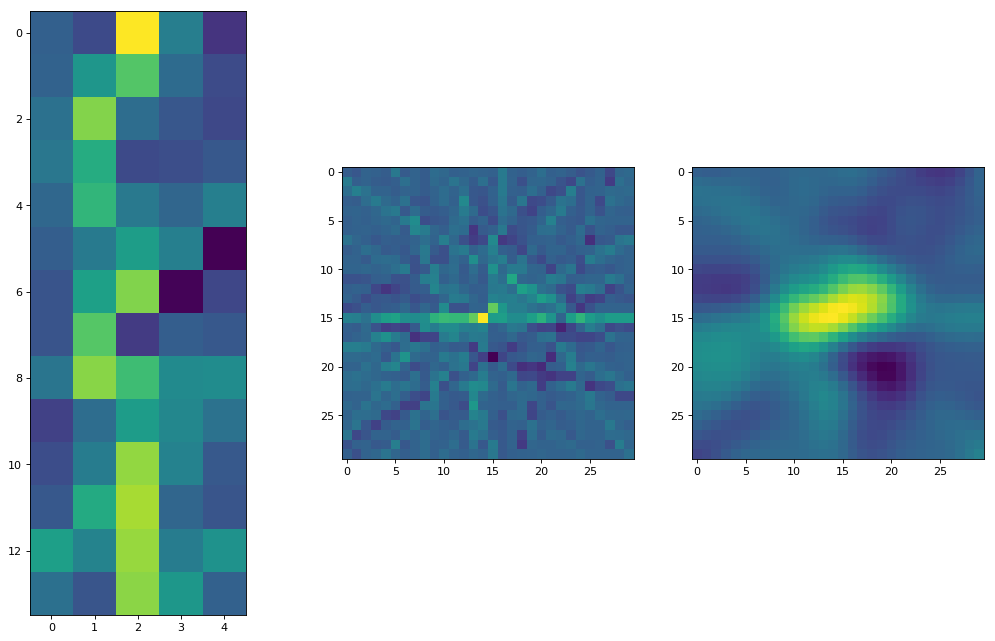

In [12]:
rela = []
for i in range(30):
    sino = sinob5(read_all())
    rel = base-sino
    rela.append(rel)
    
print('Done recording')



In [15]:
i = 0
for rel in rela:
    i += 1
    s, rec, blurred = recon(rel, str(i) + 'drill.png', 'FBP', 1, False)
    print(i)
    plt.imshow(blurred)
    plt.savefig('drill'+str(i)+'.png')
    plt.clf()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


<Figure size 432x288 with 0 Axes>

In [16]:
plt.imshow(ims[9])

NameError: name 'ims' is not defined

In [19]:
base = sinob5(read_all())

In [20]:
rela = []

In [80]:
sino = sinob5(read_all())
rel = base-sino
rela.append(rel)
print(len(rela))

60


In [81]:
i = 0
for rel in rela:
    i += 1
    s, rec, blurred = recon(rel, str(i) + 'finger.png', 'FBP', 1, False)
    print(i)
    plt.imshow(blurred)
    plt.savefig('finger'+str(i)+'.png')
    plt.clf()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


<Figure size 432x288 with 0 Axes>

In [ ]:
# Timing it

def read_all():
    r = ser.read_all() # clear buffer
    ser.write(b'a')
    while ser.in_waiting < 1:
        pass # wait for a response
    time.sleep(0.007)
    r = ser.read_all()
    if not 'A' in str(r):
        print('NO A!')
    return([int(i) for i in r.split(b'\t')[:-1]])

a = time.time()

sino = read_all()

b = time.time()

print(b-a)
print(len(sino))

# Comparing offset to regular - image recon error